# Plotting CO Ice for the Filament

In [69]:
print('test')

test


In [70]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import simple_norm
import astropy.units as u 
from astropy.coordinates import SkyCoord
import regions
from regions import Regions
from astropy.table import Table
import os

from spectral_cube import SpectralCube
import importlib as imp

from dust_extinction.averages import CT06_MWLoc, I05_MWAvg, CT06_MWGC, G21_MWAvg, RL85_MWGC, RRP89_MWGC, F11_MWGC

In [171]:
cd ..

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament


In [172]:
from jwst_plots import JWSTCatalog, make_cat_use, make_brick_cat
import cutout_manager as cm
import jwst_plots
import co_ice as co_map
imp.reload(co_map)
import extinction as ex

In [173]:
cd notebooks

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament/notebooks


In [74]:
import icemodels
imp.reload(icemodels)
from icemodels.core import optical_constants_cache_dir, read_ocdb_file, download_all_ocdb, composition_to_molweight
from icemodels import absorbed_spectrum, absorbed_spectrum_Gaussians, convsum, fluxes_in_filters, load_molecule, load_molecule_ocdb, atmo_model, molecule_data
from icemodels.gaussian_model_components import co_ice_wls_icm, co_ice_wls, co_ice_widths, co_ice_bandstrength
from astroquery.svo_fps import SvoFps
from astropy import table
co_ice_wls, co_ice_widths

(<Quantity [4.66483183, 4.67311557, 4.68055231] um>,
 <Quantity [0.0065282 , 0.0076433 , 0.02322202] um>)

## Catalog

In [6]:
cat_use = make_cat_use()

In [7]:
pos = SkyCoord('17:46:20.6290029866', '-28:37:49.5114204513', unit=(u.hour, u.deg))
l = 113.8*u.arcsec
w = 3.3*u.arcmin
reg = regions.RectangleSkyRegion(pos, width=l, height=w)

cutout_filament = cm.Cutout(pos, w, l)
cutout_405 = cutout_filament.get_cutout_405()

In [8]:
cat_filament = JWSTCatalog(cat_use.table_region_mask([reg], cutout_405.wcs))
mask_red = (cat_filament.color('f182m', 'f212n') > 0.5) | (np.isnan(np.array(cat_filament.band('f182m'))) & np.isnan(np.array(cat_filament.band('f187n'))))
mask_red = mask_red & (cat_filament.color('f410m', 'f466n') < 0)
cat_filament = JWSTCatalog(cat_filament.catalog[mask_red])

In [9]:
reg_f = Regions.read('/orange/adamginsburg/jwst/cloudc/lactea-filament/lactea-filament/regions_/filament_short.region')
cat_f = JWSTCatalog(cat_use.table_region_mask(reg_f, cutout_405.wcs))
mask_red = (cat_f.color('f182m', 'f212n') > 0.5) | (np.isnan(np.array(cat_f.band('f182m'))) & np.isnan(np.array(cat_f.band('f187n')))) 
mask_red = mask_red & (cat_f.color('f410m', 'f466n') < 0)
cat_f = JWSTCatalog(cat_f.catalog[mask_red])

(0.0, 3.0)

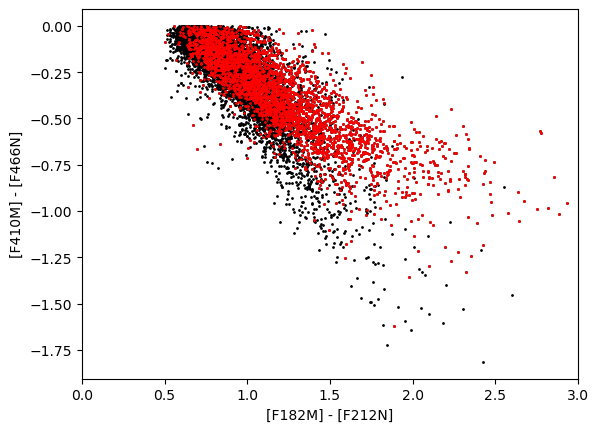

In [10]:
ax = plt.subplot(111)
cat_filament.plot_CCD('f182m', 'f212n', 'f410m', 'f466n', ax=ax, color='k', s=1)
cat_f.plot_CCD('f182m', 'f212n', 'f410m', 'f466n', ax=ax, color='r', s=1)
ax.set_xlim(0, 3)

(0.2650552069481028, 3.0)

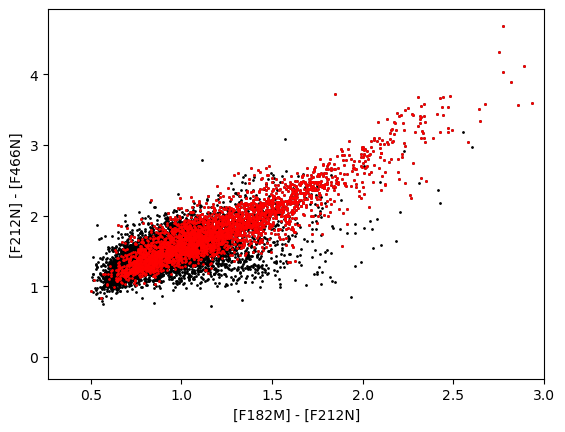

In [11]:
cat_filament.plot_CCD('f182m', 'f212n', 'f212n', 'f466n', color='k', s=1)
cat_f.plot_CCD('f182m', 'f212n', 'f212n', 'f466n', color='r', s=1)
plt.xlim(right=3)

(0.0, 3.0)

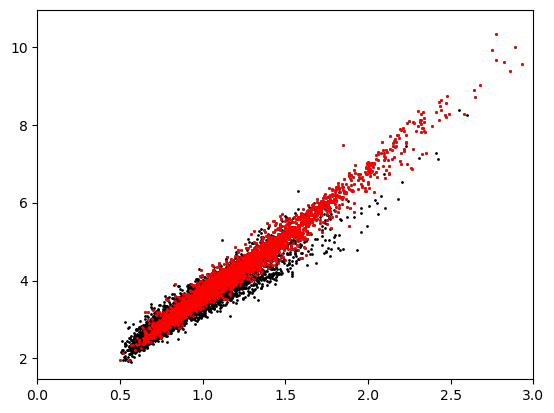

In [12]:
ax = plt.subplot(111)
color_212466_unex = co_map.unextinct(cat_filament, ext=CT06_MWLoc(), band1='f212n', band2='f466n', Av=cat_filament.get_Av('f182m', 'f212n', ext=CT06_MWLoc()))
plt.scatter(cat_filament.band('f182m') - cat_filament.band('f212n'), color_212466_unex, color='k', s=1)
color_212466_unex = co_map.unextinct(cat_f, ext=CT06_MWLoc(), band1='f212n', band2='f466n', Av=cat_f.get_Av('f182m', 'f212n', ext=CT06_MWLoc()))
plt.scatter(cat_f.band('f182m') - cat_f.band('f212n'), color_212466_unex, color='r', s=1)
#cat_filament.plot_CCD('f182m', 'f212n', 'f212n', 'f466n', ax=ax, color='k', s=1)
#cat_f.plot_CCD('f182m', 'f212n', 'f212n', 'f466n', ax=ax, color='r', s=1)
ax.set_xlim(0, 3)

## CO Ice

In [174]:
consts_file = '75_CO_1_15.0K.txt'#'1_CO_(1)_12.5K_Baratta.txt'

cat_filament = JWSTCatalog(cat_use.table_region_mask([reg], cutout_405.wcs))
mask_red = (cat_filament.color('f182m', 'f212n') > 0.5) | (np.isnan(np.array(cat_filament.band('f182m'))) & np.isnan(np.array(cat_filament.band('f187n'))))
mask_red = mask_red & (~np.isnan(np.array(cat_filament.band('f405n'))) & ~np.isnan(np.array(cat_filament.band('f410m'))))
#mask_red = mask_red & (cat_filament.color('f212n', 'f466n') < 0)
cat_filament = JWSTCatalog(cat_filament.catalog[mask_red])

Av_182212 = cat_filament.get_Av('f182m', 'f212n', ext=CT06_MWLoc())
cat_filament.catalog['N(CO)'] = co_map.get_co_column(cat_filament, Av_182212, ext=CT06_MWLoc(), ref_band='f410m',
                                consts_file=consts_file)
cat_filament.catalog['N(CO)'][cat_filament.catalog['N(CO)'] == 1e15] = np.nan

In [100]:
# Measurements from https://arxiv.org/pdf/2301.09140 
J11 = [95, 10**(18.6)]
NIR38 = [60, 10**(18.5)]
Elias16 = [19, 10**(18.3)]

Text(0.5, 1.0, '75_CO_1_15.0K')

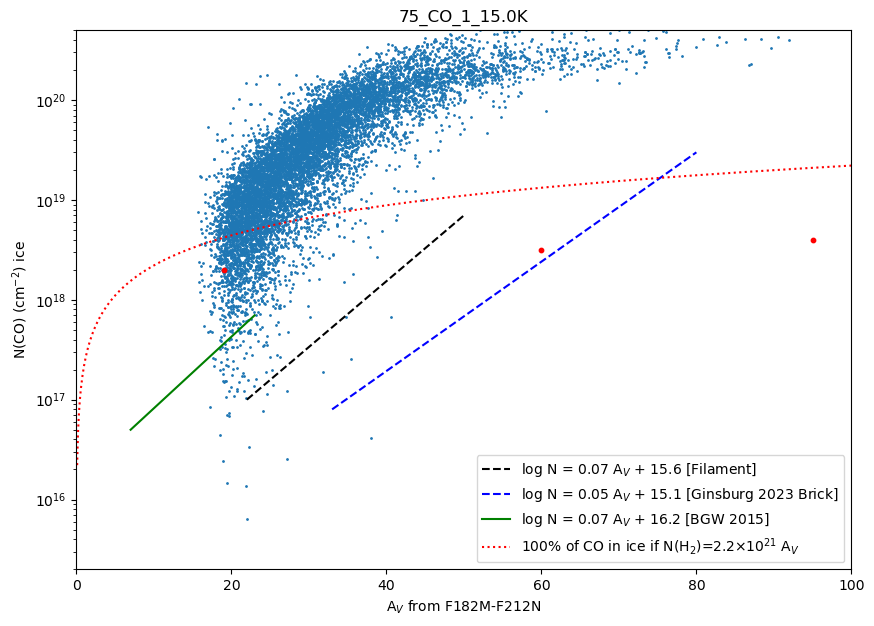

In [175]:
fig = plt.figure(figsize=(10, 7))
co_map.plot_Av_COice(Av_182212, cat_filament.catalog['N(CO)'], s=1, color='tab:blue', extras=True)
plt.scatter(J11[0], J11[1], color='r', s=10, label='J110621')
plt.scatter(NIR38[0], NIR38[1], color='r', s=10, label='NIR38')
plt.scatter(Elias16[0], Elias16[1], color='r', s=10, label='Elias 16')
plt.yscale('log')
plt.xlabel('A$_V$ from F182M-F212N')
plt.ylabel('N(CO) (cm$^{-2}$) ice')
plt.xlim(0, 100)
plt.title(consts_file[:-4])

In [15]:
co_col_map = co_map.make_co_column_map(cat_filament, cat_filament.catalog['N(CO)'], cutout_405.wcs, cutout_405.shape, fwhm=30, k=5)

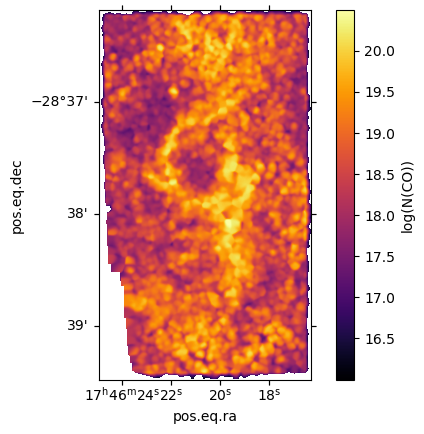

In [16]:
co_col_map[co_col_map < 1e16] = np.nan
ax = plt.subplot(projection=cutout_405.wcs)
im = ax.imshow(np.log10(co_col_map), origin='lower', cmap='inferno')
plt.colorbar(im, ax=ax, label='log(N(CO))')

# Dealing with Spectrum

In [84]:
filter_data = SvoFps.get_filter_list('JWST', instrument="NIRCam")
filter_data.add_index('filterID')
flxd = filter_data['filterID']
jfilts = SvoFps.get_filter_list('JWST')
jfilts.add_index('filterID')

In [85]:
tbl = Table.read('/orange/adamginsburg/jwst/cloudc/spectra/J110621_JWST_NIRSpec_FS_spectrum_McClure23.txt', comment=';;;', format='ascii', names=['Wavelength (micron)', 'Flux (mJy)', 'u_Flux (mJy)'])
tbl['Flux (erg Hz-1 s-1 cm-2)'] = (tbl['Flux (mJy)']*u.mJy).to(u.erg/u.Hz/u.s/u.cm**2, u.spectral_density(tbl['Wavelength (micron)']*u.um))

In [132]:
spec = tbl['Flux (erg Hz-1 s-1 cm-2)']
xarr = tbl['Wavelength (micron)']*u.um
phx4000 = atmo_model(4000, xarr=xarr)
cmd_x = ('JWST/NIRCam.F410M', 'JWST/NIRCam.F466N', 'JWST/NIRCam.F405N')
flxd_ref = fluxes_in_filters(xarr, phx4000['fnu'].quantity)
flxd = fluxes_in_filters(xarr, spec.quantity)
# the star's magnitude
mags_x_star = (-2.5*np.log10(flxd_ref[cmd_x[0]] / u.Quantity(jfilts.loc[cmd_x[0]]['ZeroPoint'], u.Jy)),
               -2.5*np.log10(flxd_ref[cmd_x[1]] / u.Quantity(jfilts.loc[cmd_x[1]]['ZeroPoint'], u.Jy)),
               -2.5*np.log10(flxd_ref[cmd_x[2]] / u.Quantity(jfilts.loc[cmd_x[2]]['ZeroPoint'], u.Jy)))
# the magnitude of the star with the CO ice
#mags_x = flxd[cmd_x[0]].to(u.ABmag).value, flxd[cmd_x[1]].to(u.ABmag).value
mags_x = (-2.5*np.log10(flxd[cmd_x[0]] / u.Quantity(jfilts.loc[cmd_x[0]]['ZeroPoint'], u.Jy)),
          -2.5*np.log10(flxd[cmd_x[1]] / u.Quantity(jfilts.loc[cmd_x[1]]['ZeroPoint'], u.Jy)),
          -2.5*np.log10(flxd[cmd_x[2]] / u.Quantity(jfilts.loc[cmd_x[2]]['ZeroPoint'], u.Jy)))

print('F466N:', mags_x[1])#-mags_x_star[1])
print('F410M:', mags_x[0])#-mags_x_star[0])
print('F405N:', mags_x[2])#-mags_x_star[2])
print('F410M - F466N = ', mags_x[0]-mags_x[1])
print('F405N - F466N = ', mags_x[2]-mags_x[1])

F466N: 16.78933347816004
F410M: 16.558976139719487
F405N: 16.377114753735423
F410M - F466N =  -0.23035733844055173
F405N - F466N =  -0.4122187244246156


In [176]:
dmag_466m410, cols = co_map.co_ice_modeling('f410m', consts_file)

In [160]:
tbl_fn = '/orange/adamginsburg/jwst/brick/tables/combined_ice_absorption_tables.ecsv'
tbl_ice_abs = Table.read(tbl_fn)
tbl_ice_abs.add_index('composition') 
molwt = composition_to_molweight('H2O:CO (10:1)')
tbl_use = tbl_ice_abs.loc['H2O:CO (10:1)']
tbl_use[:2]

molecule,mol_id,molwt,database,author,composition,temperature,density,column,F356W,F410M,F444W,F466N,F405N
,,u,,,,,g / cm3,,,,,,
str37,int64,float64,str5,str34,str66,str5,float64,float64,float64,float64,float64,float64,float64
coplush2o,5,18.923910454545453,mymix,"Mastrapa 2024, Gerakines 2020, etc",H2O:CO (10:1),25.0,1.0,1000000000000000.0,3.183087644131888e-06,8.092935463110962e-06,1.2664519674743246e-05,3.820270411836191e-05,7.4045201081673895e-06
coplush2o,5,18.923910454545453,mymix,"Mastrapa 2024, Gerakines 2020, etc",H2O:CO (10:1),25.0,1.0,1778279410038922.8,5.660411153129985e-06,1.4391494838505992e-05,2.2520952287052864e-05,6.79335655782154e-05,1.3167305576544663e-05


In [150]:
cols = tbl_use['column']
dmag_466m410 = tbl_use['F466N'] - tbl_use['F410M']

In [151]:
col_Av = [95]
col_mag410 = [mags_x[0]]
col_mag466 = [mags_x[1]]
col_mag405 = [mags_x[2]]
col_skycoord_ref = [SkyCoord('11:06:21.64 -77:23:54.12', unit=(u.hour, u.deg), frame='fk5')]

cat = JWSTCatalog(table.Table({'Av': col_Av, 'mag_ab_f410m': col_mag410, 'mag_ab_f466n': col_mag466, 'skycoord_ref': col_skycoord_ref, 'mag_ab_f405n': col_mag405}))
unextincted_color = co_map.unextinct(cat, ext=CT06_MWLoc(), band1='f466n', band2='f410m', Av=95)
#
co_col = np.interp(unextincted_color, dmag_466m410[cols<1e21], cols[cols<1e21])

In [152]:
# measured column density
np.log10(J11[1])

18.6

In [177]:
19.1/18.6

1.0268817204301075

In [181]:
(1/(2136.4*u.cm**-1)).to(u.um)

<Quantity 4.68077139 um>

In [168]:
np.log10(co_col/14)

array([18.65870994])

In [157]:
#dmag_466m410, cols = co_map.co_ice_modeling('f405n', consts_file)
dmag_466m405 = tbl_use['F466N'] - tbl_use['F405N']

In [158]:
unextincted_color = co_map.unextinct(cat, ext=CT06_MWLoc(), band1='f466n', band2='f405n', Av=95)
co_col = np.interp(unextincted_color, dmag_466m405[cols<1e21], cols[cols<1e21])

In [159]:
np.log10(co_col)

array([19.80483798])

In [104]:
ext = CT06_MWLoc()
(mags_x[1]-mags_x[0]) + (ext(410/100*u.um) - ext(466/100*u.um)) * 95

<Quantity 0.66196345>

(-2.5, 0.5)

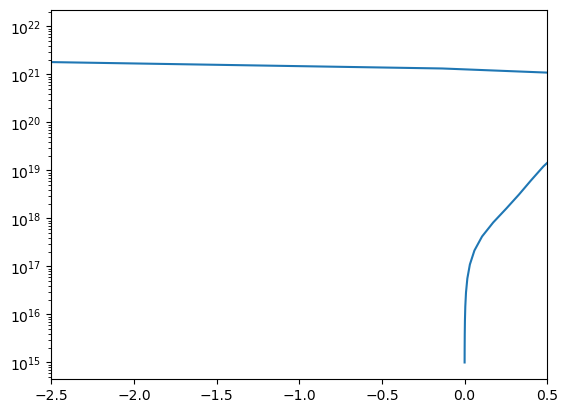

In [63]:
plt.plot(dmag_466mref, cols, color='tab:blue')
plt.yscale('log')
plt.xlim(-2.5, 0.5)